# Damped-Local-Trend(DLT) Example

In [2]:
import pandas as pd
import numpy as np
from orbit.models.dlt import DLTMAP
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components

## Data

In [3]:
DATA_FILE = "./data/iclaims_example.csv"

In [4]:
df = pd.read_csv(DATA_FILE, parse_dates=['week'])

In [5]:
df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.183973,0.720140,1.119669
1,2010-01-10,825891,1.183973,0.814896,1.178599
2,2010-01-17,659173,1.203382,0.739091,1.119669
3,2010-01-24,507651,1.164564,0.814896,1.107883
4,2010-01-31,538617,1.086926,0.776993,1.072525


## The DLT Model

Just like `orbit.lgt.LGT` it is a variation of traditional exponential smoothing models.  The difference between `DLT` and `LGT` are mainly:

- It introduces a damped factor on local trend
- It models global trend as a determinstic projection

There are four options in modeling the `global trend` with the `global_trend_option` arguemnt:

1. `linear`
2. `loglinear`
3. `logistic`
4. `flat`

The behavior of these three options will depend on the condition of `is_multiplicative` as well.  Below, we only show cases with condition when `is_multiplicative` as `True` since it is the default.

## Linear Trend

In multiplicative model, the linear trend as default will be transformed as exponential growh/decay.

In [6]:
dlt = DLTMAP(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=2020,
    is_multiplicative=True,
)

In [7]:
dlt.fit(df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_01620d4fd475c17b780fec90884e6810 NOW.


In [8]:
from datetime import timedelta
num_periods = 52 * 4
freq = 7
date_col = dlt.date_col
last_dt = (df[date_col].dt.to_pydatetime())[-1]
dts = [last_dt + timedelta(days=x * freq) for x in range(1, num_periods + 1)]
future_df = pd.DataFrame(dts, columns=[date_col])

In [9]:
predicted_df = dlt.predict(df=future_df, decompose=True)

In [10]:
predicted_df.tail(3)

,week,prediction,trend,seasonality,regression
205,2022-06-05,136785.092110,135402.089952,1.010214,1.0
206,2022-06-12,130703.163752,135102.659910,0.967436,1.0
207,2022-06-19,139600.536905,134803.892031,1.035582,1.0


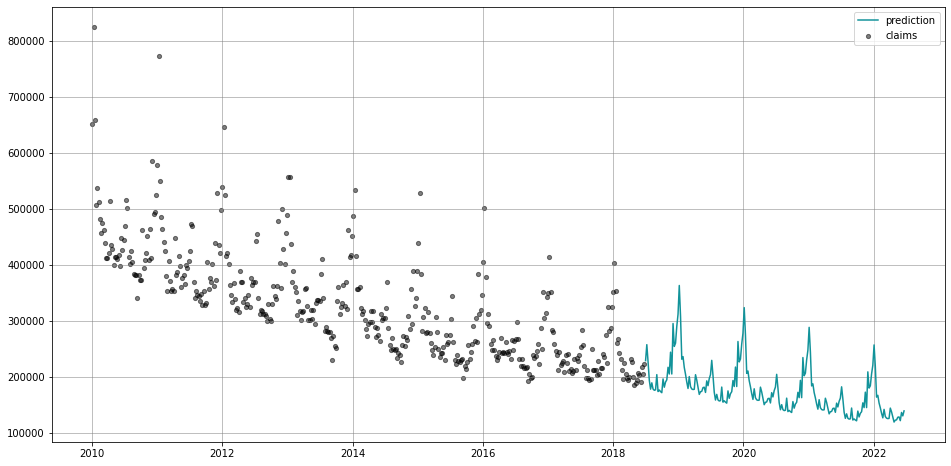

In [11]:
plot_predicted_data(training_actual_df=df, predicted_df=predicted_df, 
                    date_col=dlt.date_col, actual_col=dlt.response_col, pred_col='prediction')

## Log-Linear Trend

For users who want to maintain linear trend assumption in the multiplicative model, they can switch to `loglinear` global trend.  

In [12]:
dlt_log = DLTMAP(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=2020,
    is_multiplicative=True,
    global_trend_option='loglinear',
)

In [13]:
dlt_log.fit(df=df)

In [14]:
predicted_df_dlt_log = dlt_log.predict(df=future_df, decompose=True)

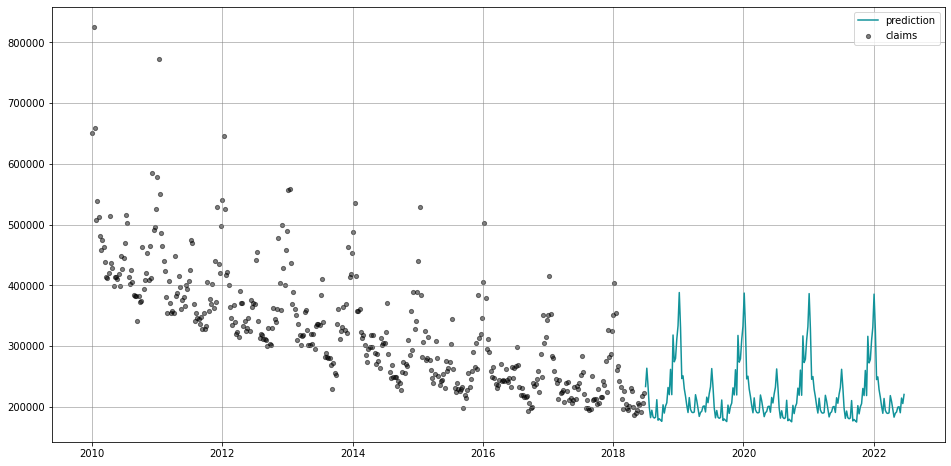

In [16]:
plot_predicted_data(training_actual_df=df, predicted_df=predicted_df_dlt_log, 
                    date_col=dlt_log.date_col, actual_col=dlt_log.response_col, pred_col='prediction')

## Logistic Global Trend

In case of modeling logistic growth/decay, user can switch to `logistic` in the `global_trend_option`. 

In [17]:
dlt_logit = DLTMAP(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=2020,
    is_multiplicative=True,
    global_trend_option='logistic',
)

In [18]:
dlt_logit.fit(df=df)

In [19]:
predicted_df_dlt_logit = dlt_logit.predict(df=future_df, decompose=True)

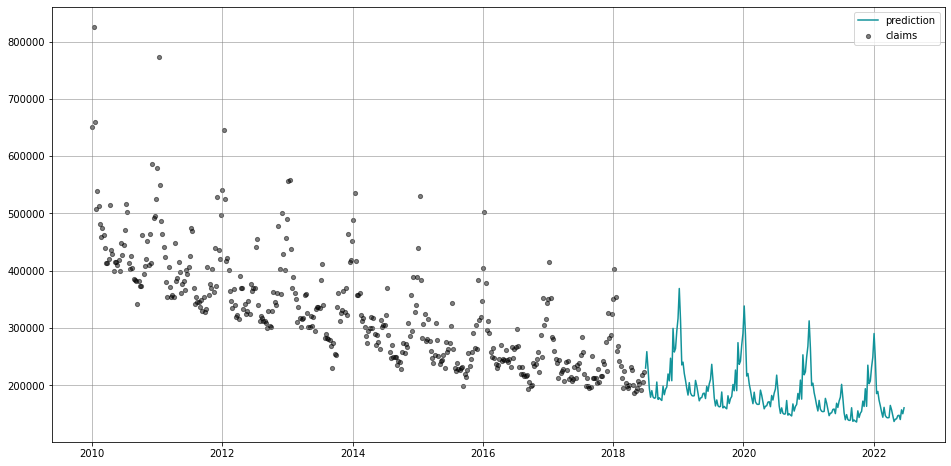

In [20]:
plot_predicted_data(training_actual_df=df, predicted_df=predicted_df_dlt_logit, 
                    date_col=dlt_log.date_col, actual_col=dlt_log.response_col, pred_col='prediction')

## Flat Global Trend

In [21]:
dlt_logit = DLTMAP(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=2020,
    is_multiplicative=True,
    global_trend_option='flat',
)

In [22]:
dlt_logit.fit(df=df)

In [23]:
predicted_df_dlt_logit = dlt_logit.predict(df=future_df, decompose=True)

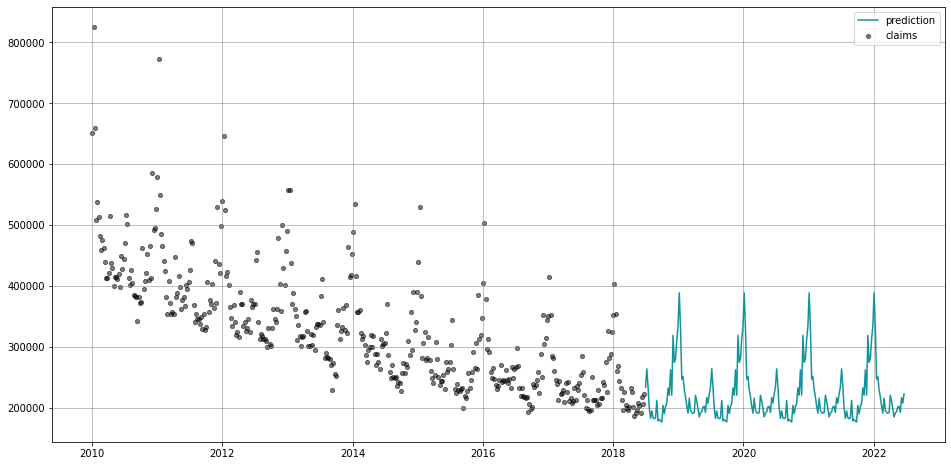

In [25]:
plot_predicted_data(training_actual_df=df, predicted_df=predicted_df_dlt_logit, 
                    date_col=dlt_log.date_col, actual_col=dlt_log.response_col, pred_col='prediction')